In [3]:
!python -m pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=c94cdce549f9e9ff6715b78f73ed9175312789ee1554c8fc4e674a6e7429b600
  Stored in directory: c:\users\student user\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import grafteaux as G
from tqdm import tqdm 


### Import PIV data

In [8]:
G = reload(G)
mpath = "C:/Users/Student User/Downloads"
X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data(mat_path = mpath)
Umean = Prof['U']


current path : C:\Users\Student User\anaconda3\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']
0.2439601862683396


In [9]:
def rf(f):
    '''
    Inverts vector data (f)
    '''
    return [f[len(f)-i-1] for i in range(len(f))]



### Function to generate low-resolution training data

In [10]:
def lowRes(pt, dim):
    '''
    input pt - Field to be converted to lower resolution
    dim - the size of the square tile which does average pooling
    return pt_ - low resolution field. 
    '''
    pt_ = np.zeros(pt.shape)
    for i in range(len(pt)):
        for j in range(len(pt[i])):
            if i< len(pt) and j < len(pt[i]): 
                pt_[i,j] = np.mean(pt[i//dim*dim:i//dim*dim+dim, j//dim*dim: j//dim*dim+dim])
            elif i>= len(pt): pt_[i,j] = np.mean(pt[i//dim*dim:, j//dim*dim: j//dim*dim+dim])
            else:             pt_[i,j] = np.mean(pt[i//dim*dim: i//dim*dim+dim, j//dim*dim:])
    
    return pt_


### Average - pooled low resolution testing

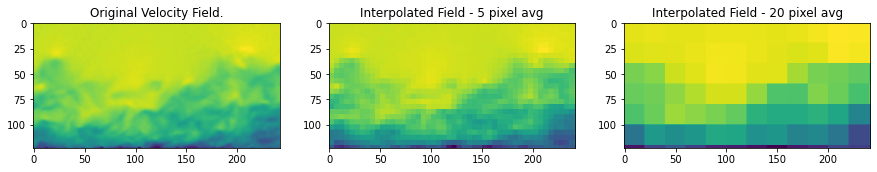

In [11]:
pt = rf(U[:,:,0])
pt2 = lowRes(np.array(pt), 5)
pt3 = lowRes(np.array(pt), 20)


plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
plt.imshow(pt/np.max(pt))
plt.title('Original Velocity Field.')
plt.subplot(1,3,2)
plt.imshow(pt2)
plt.title('Interpolated Field - 5 pixel avg')
plt.subplot(1,3,3)
plt.imshow(pt3)
plt.title('Interpolated Field - 20 pixel avg')
plt.show()

### Generating training data from PIV data

In [12]:
data_ins = []
data_outs = []

dim = 15
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T

for i in tqdm(range(750)):
    
    c_frame = U[:,:,i]-umean2
    c_frame = c_frame/np.nanmax(c_frame)
    
    do = (c_frame).flatten()
    di = lowRes(c_frame,5).flatten()
    data_ins.append(np.nan_to_num(di))
    data_outs.append(np.nan_to_num(do))

100%|██████████| 750/750 [02:59<00:00,  4.19it/s]


### Spliting into training and validation data

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data_ins, data_outs, test_size=0.1, shuffle= True)

#### looking at a sample training input and training output

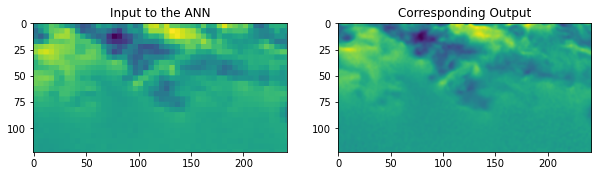

In [14]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(np.array(x_train[0]).reshape(pt2.shape))
plt.title('Input to the ANN')
plt.subplot(1,2,2)
plt.imshow(np.array(y_train[0]).reshape(pt2.shape))
plt.title('Corresponding Output')
plt.show()


### Building the ANN - Keras Sequential Model

In [15]:
#swish activation function - basically relu but better

from tensorflow.keras.backend import sigmoid
from tensorflow.python.keras.utils.generic_utils import get_custom_objects 
from tensorflow.keras.layers import Activation 

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)}) 


### ANN model 

#### Benjamen et al.(2020) Shallow decoder model parameters for forced isotropic turbulence superresolution

In [49]:

from tensorflow.keras import initializers

input_shape = pt2.flatten().shape

model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Dense(300,
                       activation = 'relu',
                       kernel_regularizer = keras.regularizers.l2(1e-7),
                       bias_initializer=initializers.Constant(0.1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(400, 
                       activation='relu',
                       kernel_regularizer = keras.regularizers.l2(1e-7),
                       bias_initializer=initializers.Constant(0.1)),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(input_shape[0])
])

adam = tf.keras.optimizers.Adam(lr=1e-2,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=None,
                                decay=0.3,
                                amsgrad=False)



In [50]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 300)               8930100   
_________________________________________________________________
batch_normalization_16 (Batc (None, 300)               1200      
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 400)               120400    
_________________________________________________________________
batch_normalization_17 (Batc (None, 400)               1600      
_________________________________________________________________
dense_26 (Dense)             (None, 29766)             11936166  
Total params: 20,989,466
Trainable params: 20,988,066
Non-trainable params: 1,400
______________________________________

### Compile and fit 

In [51]:

model.compile(optimizer=adam ,
              loss='mean_squared_error',
              metrics=['mse'])

history = model.fit(np.array(x_train),
                    np.array(y_train),
                    shuffle = True,
                    validation_split = 0,
                    epochs=200,
                    batch_size=100,
                    validation_data = (np.array(x_valid), np.array(y_valid)))



Epoch 1/200
7/7 [==============================] - 2s 246ms/step - loss: 0.1593 - mse: 0.1592 - val_loss: 2.0000 - val_mse: 1.9997
Epoch 2/200
7/7 [==============================] - 2s 226ms/step - loss: 0.0604 - mse: 0.0601 - val_loss: 0.7161 - val_mse: 0.7159
Epoch 3/200
7/7 [==============================] - 1s 203ms/step - loss: 0.0476 - mse: 0.0473 - val_loss: 0.5454 - val_mse: 0.5451
Epoch 4/200
7/7 [==============================] - 1s 193ms/step - loss: 0.0423 - mse: 0.0420 - val_loss: 0.2566 - val_mse: 0.2563
Epoch 5/200
7/7 [==============================] - 1s 191ms/step - loss: 0.0394 - mse: 0.0391 - val_loss: 0.1969 - val_mse: 0.1966
Epoch 6/200
7/7 [==============================] - 1s 193ms/step - loss: 0.0374 - mse: 0.0371 - val_loss: 0.1154 - val_mse: 0.1151
Epoch 7/200
7/7 [==============================] - 1s 191ms/step - loss: 0.0363 - mse: 0.0360 - val_loss: 0.0987 - val_mse: 0.0984
Epoch 8/200
7/7 [==============================] - 1s 196ms/step - loss: 0.0352 - m

7/7 [==============================] - 1s 198ms/step - loss: 0.0263 - mse: 0.0259 - val_loss: 0.0325 - val_mse: 0.0322
Epoch 64/200
7/7 [==============================] - 1s 194ms/step - loss: 0.0262 - mse: 0.0258 - val_loss: 0.0324 - val_mse: 0.0321
Epoch 65/200
7/7 [==============================] - 1s 193ms/step - loss: 0.0257 - mse: 0.0254 - val_loss: 0.0324 - val_mse: 0.0321
Epoch 66/200
7/7 [==============================] - 1s 197ms/step - loss: 0.0257 - mse: 0.0254 - val_loss: 0.0324 - val_mse: 0.0320
Epoch 67/200
7/7 [==============================] - 1s 194ms/step - loss: 0.0256 - mse: 0.0253 - val_loss: 0.0323 - val_mse: 0.0320
Epoch 68/200
7/7 [==============================] - 1s 191ms/step - loss: 0.0259 - mse: 0.0256 - val_loss: 0.0322 - val_mse: 0.0319
Epoch 69/200
7/7 [==============================] - 1s 194ms/step - loss: 0.0257 - mse: 0.0253 - val_loss: 0.0322 - val_mse: 0.0319
Epoch 70/200
7/7 [==============================] - 1s 193ms/step - loss: 0.0255 - mse: 0

Epoch 125/200
7/7 [==============================] - 1s 196ms/step - loss: 0.0235 - mse: 0.0232 - val_loss: 0.0310 - val_mse: 0.0307
Epoch 126/200
7/7 [==============================] - 1s 195ms/step - loss: 0.0233 - mse: 0.0230 - val_loss: 0.0310 - val_mse: 0.0307
Epoch 127/200
7/7 [==============================] - 1s 193ms/step - loss: 0.0234 - mse: 0.0231 - val_loss: 0.0309 - val_mse: 0.0306
Epoch 128/200
7/7 [==============================] - 1s 197ms/step - loss: 0.0233 - mse: 0.0229 - val_loss: 0.0309 - val_mse: 0.0306
Epoch 129/200
7/7 [==============================] - 1s 194ms/step - loss: 0.0233 - mse: 0.0230 - val_loss: 0.0309 - val_mse: 0.0306
Epoch 130/200
7/7 [==============================] - 1s 196ms/step - loss: 0.0232 - mse: 0.0229 - val_loss: 0.0309 - val_mse: 0.0306
Epoch 131/200
7/7 [==============================] - 1s 212ms/step - loss: 0.0235 - mse: 0.0232 - val_loss: 0.0309 - val_mse: 0.0306
Epoch 132/200
7/7 [==============================] - 1s 208ms/step - 

7/7 [==============================] - 1s 208ms/step - loss: 0.0219 - mse: 0.0216 - val_loss: 0.0302 - val_mse: 0.0299
Epoch 187/200
7/7 [==============================] - 1s 205ms/step - loss: 0.0219 - mse: 0.0216 - val_loss: 0.0302 - val_mse: 0.0299
Epoch 188/200
7/7 [==============================] - 1s 196ms/step - loss: 0.0219 - mse: 0.0216 - val_loss: 0.0302 - val_mse: 0.0299
Epoch 189/200
7/7 [==============================] - 1s 211ms/step - loss: 0.0218 - mse: 0.0215 - val_loss: 0.0302 - val_mse: 0.0299
Epoch 190/200
7/7 [==============================] - 1s 209ms/step - loss: 0.0217 - mse: 0.0214 - val_loss: 0.0302 - val_mse: 0.0298
Epoch 191/200
7/7 [==============================] - 1s 198ms/step - loss: 0.0221 - mse: 0.0217 - val_loss: 0.0302 - val_mse: 0.0298
Epoch 192/200
7/7 [==============================] - 1s 196ms/step - loss: 0.0220 - mse: 0.0217 - val_loss: 0.0301 - val_mse: 0.0298
Epoch 193/200
7/7 [==============================] - 1s 196ms/step - loss: 0.0216 -

#### Save the ANN model

In [21]:
#model.save('C:/Users/Kommalapati sahil/Desktop/Brunton/ANN10k')-

### Training and testing convergence histories

In [23]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

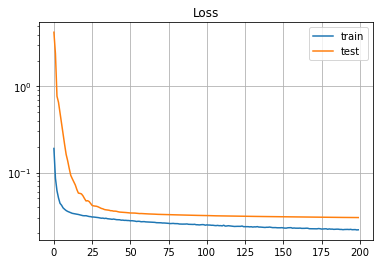

In [25]:

plt.title('Loss')
plt.semilogy(history.history['mse'], label='train')
plt.semilogy(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

### Reconstructed high resolution Images from ANN 

#### Using Validation cases

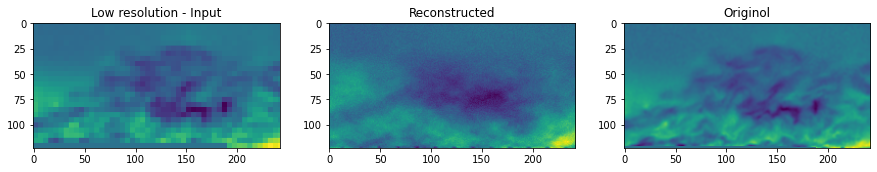

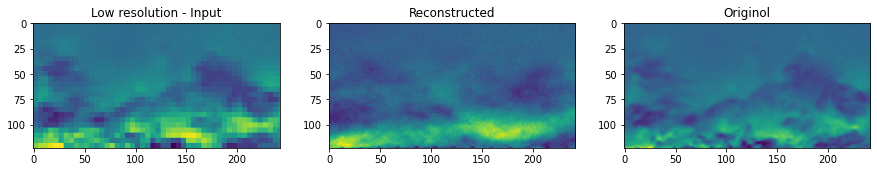

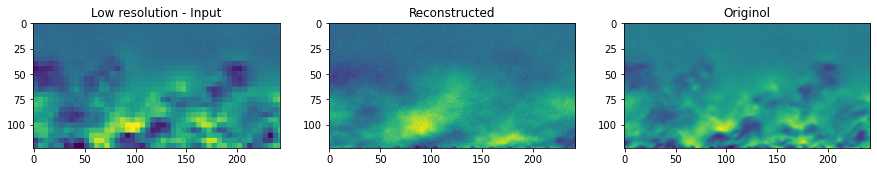

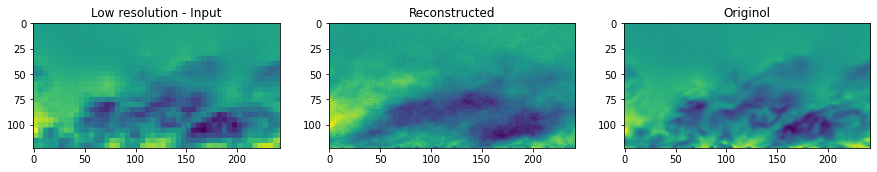

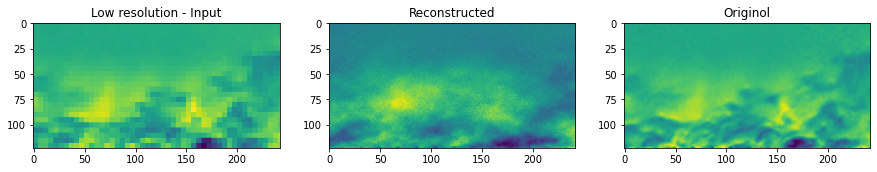

In [26]:
for i in range(5):
    plt.figure(figsize = (15,10))

    plt.subplot(1,3,1)
    plt.imshow(rf(x_valid[i].reshape(pt2.shape)))
    plt.title('Low resolution - Input')
    y_pred0 = model.predict(np.array([x_valid[i]]))

    plt.subplot(1,3,2)
    plt.imshow(rf(y_pred0.reshape(pt2.shape)))
    plt.title('Reconstructed')

    plt.subplot(1,3,3)
    plt.imshow(rf(y_valid[i].reshape(pt2.shape)))
    plt.title('Originol')
    plt.show()